# Predicting FRET

This tutorial demonstrates how to perform an *in silico* FRET experiment using the external package [*FRETtraj*](https://rna-fretools.github.io/fretraj/intro.html) on the basis of an MD simulation with explicit fluorophores attached via *FRETlabel*.

## Extraction of $R(t)$ and $\kappa ^2(t)$
Built-in GROMACS tools can be used to extract the interdye-distance $R_\text{DA}$ and the orientation factor $\kappa ^2$.

First, define the dipole vector by an atom pair for each of the two dyes. You may either select the atoms based on their indices with `gmx make_ndx` or more expressively by reading in an atom selection with `gmx select`. To this end, save the following to a text file named *dye_selection.txt* (here atom names C2 and C14 define the dipole vector of the dye residues C3W and C5W)
```
"Cy3_C2C14" resname C3W and (name C2 or name C14)
"Cy5_C2C14" resname C5W and (name C2 or name C14)
```

Then run `gmx select` on a reference pdb file to get a new index file called *dyes.ndx*
```
gmx select -s DNA.pdb -on dyes.ndx < dye_selection.txt
```

Now, extract $R_{DA}$ and $\kappa ^2$ using `gmx dyecoupl` (Hoefling et al., *Comput. Phys. Commun.* **2013** {cite}`Hoefling.2013`) which is built into GROMACS. 

```
gmx dyecoupl -f DNA.xtc -n dyes.ndx -o DNA_rkappa.dat
```

To calculate **anisotropy decays** also extract the coordinates of the atoms defining the dipole vector

```
gmx traj -f DNA.xtc -s DNA.pdb -n dyes.ndx -ox DNA_donor_coords.xvg
gmx traj -f DNA.xtc -s DNA.pdb -n dyes.ndx -ox DNA_acceptor_coords.xvg
```

## Simulating photons with *FRETraj*

In [1]:
import fretraj as ft
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit

The parameter file *DNA_parameters.json* defines bursts settings, the experimental inputs (fluorescence lifetime, quantum yields) and the file paths.

In [2]:
parameters = ft.burst.readParameters('../data/DNA_parameters.json')

Next, initialize a new experiment including calculation of the time-resolved anisotropy

In [3]:
experiment = ft.burst.Experiment('../data', parameters, compute_anisotropy=True)

Loading files...


Orientation independent R0_const = 5.8 A

              donor    acceptor
QY            0.20    0.30
tau (ns)      0.75    1.50
k_f (ns^-1)   0.27    0.20
k_ic (ns^-1)  1.07    0.47
              
Burst averaging method: all
Calculate anisotropy: yes



Calculating bursts:   0%|          | 0/2000 [? s]

Combining burst...




average FRET efficiency: 0.42 +- 0.09



Plot the **FRET distribution** and fit a normal distribution to the data.

In [4]:
hist, bins = np.histogram(experiment.FRETefficiencies, bins=20, range=(0,1))
bincenters = binMid = (bins[1:]+bins[:-1])/2

In [5]:
model = lmfit.models.GaussianModel()
pars = model.guess(hist, x=bincenters)
out = model.fit(hist, pars, x=bincenters)
x_fit = np.linspace(0,1,100)
y_fit = model.func(x_fit, *list(out.params.valuesdict().values())[:3])

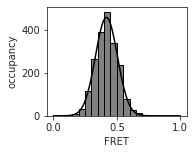

In [6]:
with sns.axes_style('ticks'):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5, 2), sharex=False, sharey=False, squeeze=False)
    plt.hist(experiment.FRETefficiencies,bins=20, range=(0,1), color='grey', edgecolor='black')
    plt.plot(x_fit, y_fit, color='k')
    ax[0,0].set_xlabel('FRET')
    ax[0,0].set_ylabel('occupancy')

Plot the **decay times** of the fluorescence emission and internal conversion for donor electrons after donor excitation and acceptor electrons upon acceptor excitation

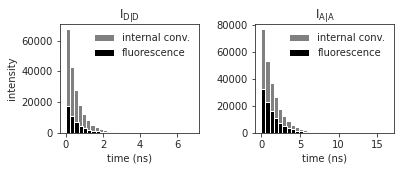

In [7]:
with sns.axes_style('ticks'):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), sharex=False, sharey=False, squeeze=False, gridspec_kw={'wspace':0.4})
    ax[0,0].hist(experiment.decaytimes_DD_DA['D_ic'], bins=30, color='grey')
    ax[0,0].hist(experiment.decaytimes_DD_DA['D_f'], bins=30, color='black')
    ax[0,1].hist(experiment.decaytimes_AA['A_ic'], bins=30, color='grey')
    ax[0,1].hist(experiment.decaytimes_AA['A_f'], bins=30, color='black')
    
    ax[0,0].legend(['internal conv.', 'fluorescence'], frameon=False)
    ax[0,1].legend(['internal conv.', 'fluorescence'], frameon=False)
    ax[0,0].set_title('$\mathregular{I_{D|D}}$')
    ax[0,1].set_title('$\mathregular{I_{A|A}}$')
    ax[0,0].set_ylabel('intensity')
    ax[0,0].set_xlabel('time (ns)')
    ax[0,1].set_xlabel('time (ns)')

Plot the **polarization resolved fluorescence decay** of the donor and the acceptor

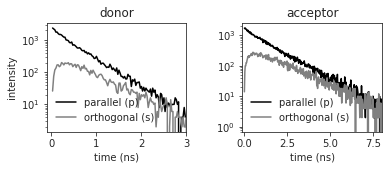

In [8]:
with sns.axes_style('ticks'):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), sharex=False, sharey=False, squeeze=False, gridspec_kw={'wspace':0.4})
    ax[0,0].semilogy(experiment.polIntensity['D_f'][:,0], experiment.polIntensity['D_f'][:,1], color='k')
    ax[0,0].semilogy(experiment.polIntensity['D_f'][:,0], experiment.polIntensity['D_f'][:,2], color='grey')
    ax[0,1].semilogy(experiment.polIntensity['A_f'][:,0], experiment.polIntensity['A_f'][:,1], color='k')
    ax[0,1].semilogy(experiment.polIntensity['A_f'][:,0], experiment.polIntensity['A_f'][:,2], color='grey')
    
    ax[0,0].legend(['parallel (p)', 'orthogonal (s)'], frameon=False)
    ax[0,1].legend(['parallel (p)', 'orthogonal (s)'], frameon=False)
    ax[0,0].set_title('donor')
    ax[0,1].set_title('acceptor')
    ax[0,0].set_ylabel('intensity')
    ax[0,0].set_xlabel('time (ns)')
    ax[0,1].set_xlabel('time (ns)')
    ax[0,0].set_xlim(-0.1,3)
    ax[0,1].set_xlim(-0.1,8)

Plot the **anisotropy decay** of the donor and acceptor fluorophore

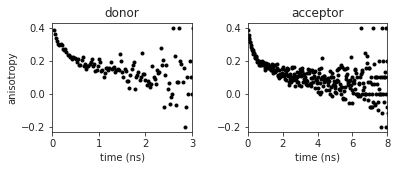

In [9]:
with sns.axes_style('ticks'):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), sharex=False, sharey=False, squeeze=False, gridspec_kw={'wspace':0.4})
    ax[0,0].plot(experiment.anisotropy['D_f'][:,0], experiment.anisotropy['D_f'][:,1], '.', color='k')
    ax[0,1].plot(experiment.anisotropy['A_f'][:,0], experiment.anisotropy['A_f'][:,1], '.', color='k')
    ax[0,0].set_ylabel('anisotropy')
    ax[0,0].set_xlabel('time (ns)')
    ax[0,1].set_xlabel('time (ns)')
    ax[0,0].set_title('donor')
    ax[0,1].set_title('acceptor')
    ax[0,0].set_xlim(0,3)
    ax[0,1].set_xlim(0,8)